### Von-Mises-Fischer dist functions

In [1]:
import numpy as np
from scipy.linalg import null_space
import numpy.matlib
import torch
import matplotlib.pyplot as plt
device = 'cpu'



# https://github.com/dlwhittenbury/von-Mises-Fisher-Sampling

def rand_uniform_hypersphere(N,p):
    
    """ 
        rand_uniform_hypersphere(N,p)
        =============================
    
        Generate random samples from the uniform distribution on the (p-1)-dimensional 
        hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$. We use the method by 
        Muller [1], see also Ref. [2] for other methods.
        
        INPUT:  
        
            * N (int) - Number of samples 
            * p (int) - The dimension of the generated samples on the (p-1)-dimensional hypersphere.
                - p = 2 for the unit circle $\mathbb{S}^{1}$
                - p = 3 for the unit sphere $\mathbb{S}^{2}$
            Note that the (p-1)-dimensional hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$ and the 
            samples are unit vectors in $\mathbb{R}^{p}$ that lie on the sphere $\mathbb{S}^{p-1}$.
    
    References:
    
    [1] Muller, M. E. "A Note on a Method for Generating Points Uniformly on N-Dimensional Spheres."
    Comm. Assoc. Comput. Mach. 2, 19-20, Apr. 1959.
    
    [2] https://mathworld.wolfram.com/SpherePointPicking.html
    
    """
    
    if (p<=0) or (type(p) is not int):
        raise Exception("p must be a positive integer.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    v = np.random.normal(0,1,(N,p))
        
    v = np.divide(v,np.linalg.norm(v,axis=1,keepdims=True))
    
    return v

def rand_t_marginal(kappa,p,N=1):
    """
        rand_t_marginal(kappa,p,N=1)
        ============================
        
        Samples the marginal distribution of t using rejection sampling of Wood [3]. 
    
        INPUT: 
        
            * kappa (float) - concentration        
            * p (int) - The dimension of the generated samples on the (p-1)-dimensional hypersphere.
                - p = 2 for the unit circle $\mathbb{S}^{1}$
                - p = 3 for the unit sphere $\mathbb{S}^{2}$
            Note that the (p-1)-dimensional hypersphere $\mathbb{S}^{p-1} \subset \mathbb{R}^{p}$ and the 
            samples are unit vectors in $\mathbb{R}^{p}$ that lie on the sphere $\mathbb{S}^{p-1}$.
            * N (int) - number of samples 
        
        OUTPUT: 
        
            * samples (array of floats of shape (N,1)) - samples of the marginal distribution of t
    """
    
    # Check kappa >= 0 is numeric 
    if (kappa < 0) or ((type(kappa) is not float) and (type(kappa) is not int)):
        raise Exception("kappa must be a non-negative number.")
        
    if (p<=0) or (type(p) is not int):
        raise Exception("p must be a positive integer.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    
    # Start of algorithm 
    b = (p - 1.0) / (2.0 * kappa + np.sqrt(4.0 * kappa**2 + (p - 1.0)**2 ))    
    x0 = (1.0 - b) / (1.0 + b)
    c = kappa * x0 + (p - 1.0) * np.log(1.0 - x0**2)
    
    samples = np.zeros((N,1))
    
    # Loop over number of samples 
    for i in range(N):
        
        # Continue unil you have an acceptable sample 
        while True: 
            
            # Sample Beta distribution
            Z = np.random.beta( (p - 1.0)/2.0, (p - 1.0)/2.0 )
            
            # Sample Uniform distribution
            U = np.random.uniform(low=0.0,high=1.0)
            
            # W is essentially t
            W = (1.0 - (1.0 + b) * Z) / (1.0 - (1.0 - b) * Z)
            
            # Check whether to accept or reject 
            if kappa * W + (p - 1.0)*np.log(1.0 - x0*W) - c >= np.log(U):
                
                # Accept sample
                samples[i] = W
                break
                          
    return samples
                
def rand_von_mises_fisher(mu,kappa,N=1):
    """
        rand_von_mises_fisher(mu,kappa,N=1)
        ===================================
        
        Samples the von Mises-Fisher distribution with mean direction mu and concentration kappa. 
        
        INPUT: 
        
            * mu (array of floats of shape (p,1)) - mean direction. This should be a unit vector.
            * kappa (float) - concentration. 
            * N (int) - Number of samples. 
        
        OUTPUT: 
        
            * samples (array of floats of shape (N,p)) - samples of the von Mises-Fisher distribution
            with mean direction mu and concentration kappa. 
    """
    
    
    # Check that mu is a unit vector
    eps = 10**(-5) # Precision 
    norm_mu = np.linalg.norm(mu)
    if abs(norm_mu - 1.0) > eps:
        print(abs(norm_mu - 1.0))
        raise Exception("mu must be a unit vector.")
        
    # Check kappa >= 0 is numeric 
    if (kappa < 0) or ((type(kappa) is not float) and (type(kappa) is not int)):
        raise Exception("kappa must be a non-negative number.")
    
    # Check N>0 and is an int
    if (N<=0) or (type(N) is not int):
        raise Exception("N must be a non-zero positive integer.")
    
    # Dimension p
    p = len(mu)
    
    # Make sure that mu has a shape of px1
    mu = np.reshape(mu,(p,1))
    
    # Array to store samples 
    samples = np.zeros((N,p))
    
    #  Component in the direction of mu (Nx1)
    t = rand_t_marginal(kappa,p,N) 
    
    # Component orthogonal to mu (Nx(p-1))
    xi = rand_uniform_hypersphere(N,p-1) 
    
    # von-Mises-Fisher samples Nxp
    
    # Component in the direction of mu (Nx1).
    # Note that here we are choosing an 
    # intermediate mu = [1, 0, 0, 0, ..., 0] later
    # we rotate to the desired mu below
    samples[:,[0]] = t 
    
    # Component orthogonal to mu (Nx(p-1))
    samples[:,1:] = np.matlib.repmat(np.sqrt(1 - t**2), 1, p-1) * xi
    
    # Rotation of samples to desired mu
    O = null_space(mu.T)
    R = np.concatenate((mu,O),axis=1)
    samples = np.dot(R,samples.T).T
    
    return samples

samples = rand_von_mises_fisher(np.array([0, 1, 0]), 1, N=100)
np.linalg.norm(samples, axis=1)


class BatchedvMF:
    def __init__(self, mu, kappa, device):
        self.mu = mu
        if not torch.allclose(torch.norm(mu, dim=1), torch.ones([mu.shape[0]]).to(device)):
            raise Exception("Mean is not on a sphere")
        self.kappa = kappa
        self.device = device

        
    def sample(self):
        batch_size = self.mu.shape[0]
        samples = []
        for i in range(batch_size):
            samples.append(rand_von_mises_fisher(np.array(self.mu[i].cpu()) / np.linalg.norm(self.mu[i].cpu()), float(self.kappa[i].cpu()), N=1))
            
        ret_val = torch.cat([torch.Tensor(item).unsqueeze(0) for item in samples], dim=0).to(self.device)
        return ret_val.squeeze()

dist = BatchedvMF(torch.Tensor([[0, 1, 0], [0, 1, 0]]).to(device), torch.Tensor([1, 0.5]).to(device), device='cpu')
samples = dist.sample()


In [3]:
from schedule import noising_sch
from functools import partial
from scipy.special import iv as I_bessel_fn
T = 100

noising_sch = partial(noising_sch, T=T)


def get_dist(k_t, x_0):
    dist = BatchedvMF(x_0, k_t, device=device)
    return dist
    
def KL(x_0, x_theta, t):
    k_t = noising_sch(t)
    k = 3
    return k_t * torch.Tensor(I_bessel_fn(k / 2, k_t.cpu().numpy()) / I_bessel_fn(k / 2 - 1, k_t.cpu().numpy())) * (x_0.T @ (x_0 - x_theta))
    
def KL(x_0, x_theta, t):
    # not exactly KL but loss function
    return torch.ones(t.shape[0]).to(device) - torch.diag(x_0 @ x_theta.T)
    
def sufficient_stats(x_t, t):
    k_t = noising_sch(t)
    return k_t * x_t
    

## Generate dataset

In [6]:
from tqdm import tqdm
batch_size = 64
def sample_chain_suff_stats_norm_alpha(t_batch, x_0):
    samples = []
    suff_stats = torch.zeros_like(x_0)
    suff_stats_normed = torch.zeros_like(x_0)
    t_min = torch.min(t_batch)
    helper = torch.Tensor([[t <= s for s in range(T + 1)] for t in t_batch]).to(device)
    
    alphas = torch.zeros_like(x_0)
    
    for s in range(T, int(t_min), -1):
        s_batch = torch.tensor([s], device=device).repeat(batch_size)
        helper_slice = helper[:, s]
        
        k_t = noising_sch(s_batch)
        
        dist = BatchedvMF(x_0, k_t, device=device)
        
        samples.append(dist.sample())
        alphas += helper_slice.reshape([-1, 1]) * k_t.reshape([-1, 1]).repeat([1, 1])
        
        suff_stats += helper_slice.reshape([-1, 1]) * sufficient_stats(samples[-1], s_batch.reshape([-1, 1]))
        
    suff_stats_normed = suff_stats / alphas
        
    return samples, suff_stats_normed


from utils import sample_t_batch
sample_t_batch = partial(sample_t_batch, T=T)


def generate_dataset(dataset, n_samples, batch_size=1024, save_path='generated_dataset.pth'):
    n_iters = n_samples // batch_size
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    x_0_storage = []
    t_batch_storage = []
    suff_stats_storage = []
    
    for i in tqdm(range(n_iters)):
        x_0 = next(iter(dataloader)).to(device)
        t_batch = sample_t_batch(batch_size)
        samples, suff_stats = sample_chain_suff_stats_norm_alpha(t_batch, x_0)
        
        x_0_storage.append(x_0.cpu())
        t_batch_storage.append(t_batch.cpu())
        suff_stats_storage.append(suff_stats.cpu())
        
    x_0_tensor = torch.cat(x_0_storage, dim=0)
    t_batch_tensor = torch.cat(t_batch_storage, dim=0)
    suff_stats_tensor = torch.cat(suff_stats_storage, dim=0)
    return x_0_tensor, t_batch_tensor, suff_stats_tensor



INFO: Using numpy backend


In [9]:

import matplotlib.pyplot as plt
def get_sphere_coords():
    radius = 1.0
    # set_aspect_equal_3d(ax)
    n = 200
    u = np.linspace(0, 2 * np.pi, n)
    v = np.linspace(0, np.pi, n)

    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))

    return x, y, z


def sphere_plot(ax, color="grey"):
    # assert manifold.dim == 2
    x, y, z = get_sphere_coords()
    ax.plot_surface(x, y, z, rstride=4, cstride=4, color=color, linewidth=0, alpha=0.2)

    return ax



## Toy Mixture Dataset

In [10]:

class vMFMixtureDataset(torch.utils.data.Dataset):
    
    def __init__(self, means, kappas, weights):
        super().__init__()
        self.cat_dist = torch.distributions.categorical.Categorical(weights)
        self.means = means
        self.kappas = kappas
        
    def __len__(self):
        return 16380
    
    def sample(self):
        idx_mixture = self.cat_dist.sample()
        ret_val = rand_von_mises_fisher(np.array(self.means[idx_mixture]), float(self.kappas[idx_mixture]), N=1)
        return torch.Tensor(ret_val).to(device).squeeze()

    def __getitem__(self, idx):
        return self.sample()
   

## Generate Mixture vMF dataset

In [13]:
vMF_Mixture = vMFMixtureDataset(torch.Tensor([[1, 0, 0], [0, -1, 0], [0, 0, 1]]), torch.Tensor([80, 80, 80]), torch.Tensor([0.33, 0.33, 0.34]))
vMF_Mixture_dataloader = torch.utils.data.DataLoader(vMF_Mixture, batch_size=batch_size, shuffle=True)

n_samples = batch_size * 3 * 100 * 5

x_0_tensor, t_batch_tensor, suff_stats_tensor = generate_dataset(vMF_Mixture, n_samples, batch_size=batch_size)

torch.save(x_0_tensor, 'vMF_Mixture_x_0_dataset.pth')
torch.save(t_batch_tensor, 'vMF_Mixture_t_batch_dataset.pth')
torch.save(suff_stats_tensor, 'vMF_Mixture_suff_stats_dataset.pth')


100%|█████████████████████████████████████████████████| 1500/1500 [25:21<00:00,  1.01s/it]


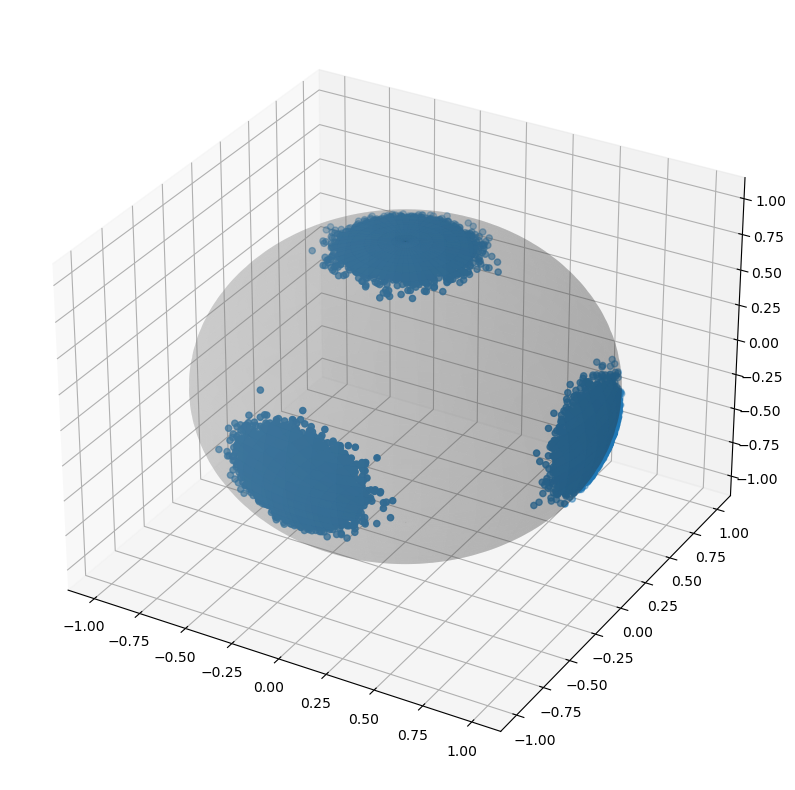

In [16]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax = sphere_plot(ax)
sample = torch.cat([item.unsqueeze(0) for item in x_0_tensor], dim=0)
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])


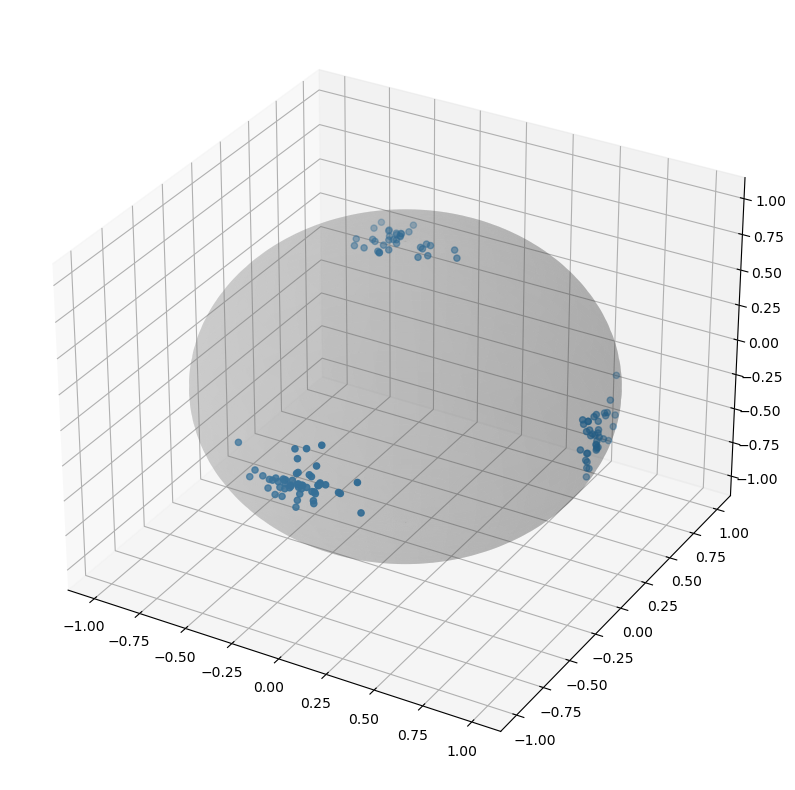

In [13]:

class vMFForwardDiffusionDataset(torch.utils.data.Dataset):
    def __init__(self, x_0_tensor, t_batch_tensor, suff_stats_tensor):
        super().__init__()
        self.x_0_tensor = x_0_tensor
        self.t_batch_tensor = t_batch_tensor
        self.suff_stats_tensor = suff_stats_tensor
        
    def __len__(self):
        return self.x_0_tensor.shape[0]
        
    def __getitem__(self, idx):
        return self.x_0_tensor[idx], self.t_batch_tensor[idx], self.suff_stats_tensor[idx]
    
x_0_tensor, t_batch_tensor, suff_stats_tensor = torch.load('vMF_Mixture_x_0_dataset.pth'), torch.load('vMF_Mixture_t_batch_dataset.pth'), torch.load('vMF_Mixture_suff_stats_dataset.pth')

forward_diffusion_dataset = vMFForwardDiffusionDataset(x_0_tensor, t_batch_tensor, suff_stats_tensor)

forward_diffusion_dataloader = torch.utils.data.DataLoader(forward_diffusion_dataset, batch_size=128, shuffle=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax = sphere_plot(ax)
sample = next(iter(forward_diffusion_dataloader))[0]
ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

## Model

In [14]:
from models import PositionalEmbedding
import torch.nn as nn

class vMFModel(nn.Module):
    def __init__(self, hidden_dim=64, time_emb_hidden_dim=16):
        super().__init__()
        base_channels = 8
        self.time_mlp = nn.Sequential(
            PositionalEmbedding(base_channels, 1.0),
            nn.Linear(base_channels, hidden_dim),
            nn.SiLU()
        )
        self.mlp_1 = nn.Sequential(nn.Linear(3, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, hidden_dim), nn.GELU())
        self.mlp_2 = nn.Linear(hidden_dim, 3)
        
    def forward(self, x, t):
        time_emb = self.time_mlp(t)
        x = self.mlp_1(x)
        x = x + time_emb
        ret_val = self.mlp_2(x)
        ret_val = ret_val / torch.norm(ret_val, dim=1).reshape(-1, 1)
        return ret_val


## Training

In [16]:


def train_generated_dataset(model, opt, dataloader, max_iter=1000):
    pbar = tqdm(range(max_iter))
    model.train()
    
    for i in pbar:
        x_0, t_batch, suff_stats = next(iter(dataloader))
        x_0, t_batch, suff_stats = x_0.to(device), t_batch.to(device), suff_stats.to(device)
        
        x_theta = model(suff_stats, t_batch)
        
        loss = KL(x_0, x_theta, t_batch).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_description(f'Iter {i} Loss: {loss.item():.4f}')
        if (i + 1) % 1000 == 0:
            torch.save(model.state_dict(), f'vMF_Mxiture_ssddpm_{i}_iter.pth')



In [56]:
model = vMFModel(hidden_dim=64, time_emb_hidden_dim=16).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [ ]:

train_generated_dataset(model, opt, forward_diffusion_dataloader, max_iter=10000)


## Generation

In [74]:


def generate_alpha_normed(model, filename='vMF_ssddpm_samples.png'):
    model.eval()
    batch_size = 4024
    
    x_T_dist = BatchedvMF(torch.Tensor([[0, 1, 0]]).to(device).repeat([batch_size, 1]), torch.Tensor([1e-4]).to(device).repeat(batch_size), device='cpu')
    x_t = x_T_dist.sample()
    
    suff_stats = sufficient_stats(x_t, torch.tensor([T], device=device).repeat(batch_size).reshape([-1, 1]))
    alphas = noising_sch(torch.tensor([T], device=device).repeat(batch_size))
    
    suff_stats_normed = suff_stats / alphas.reshape([-1, 1]).repeat([1, 3])
    
    samples_history = []
    x_0_samples_history = []
    for t in tqdm(range(T, 1, -1)):
        t_batch = torch.tensor([t], device=device).repeat(batch_size)
        x_0 = model(suff_stats_normed, t_batch)
        
        mu = noising_sch(t_batch)
        alphas += mu
        
        dist = get_dist(mu, x_0)
        x_t = dist.sample()
        
        x_0_samples_history.append(x_0.detach().cpu())
        samples_history.append(x_t)
        
        alphas += mu
        
        suff_stats += sufficient_stats(x_t, torch.tensor([t - 1], device=device).repeat(batch_size).reshape([-1, 1]))
        
        suff_stats_normed = suff_stats / alphas.reshape([-1, 1]).repeat([1, 3])
    
    t_batch = torch.tensor([1], device=device).repeat(batch_size)
    x_0 = model(suff_stats_normed, t_batch)
    
    return x_0, samples_history, x_0_samples_history


100%|█████████████████████████████████████████████████████| 99/99 [00:55<00:00,  1.77it/s]


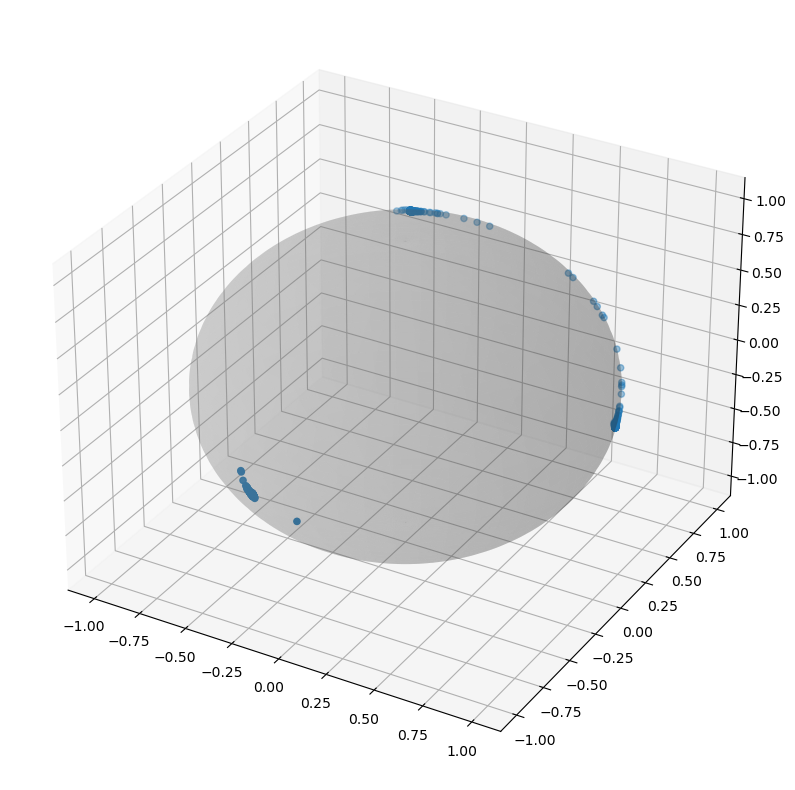

In [75]:
with torch.no_grad():
    x_0, samples_history, x_0_samples_history = generate_alpha_normed(model)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
sample = x_0.cpu().numpy()

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

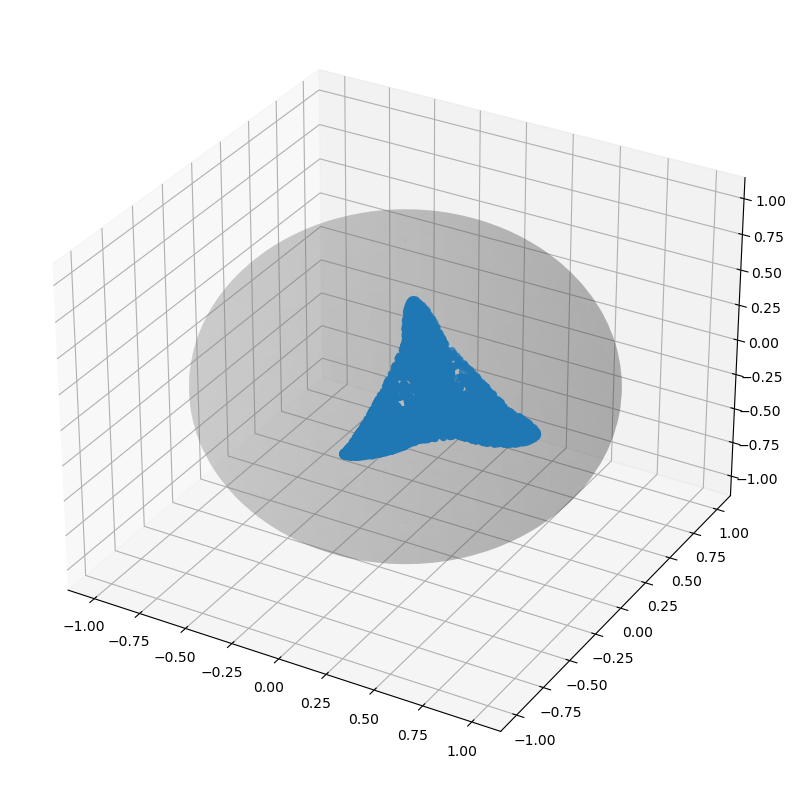

In [85]:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax = sphere_plot(ax)
# sample = x_0.cpu().numpy()
sample = x_0_samples_history[-99].cpu().numpy()

ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2])

## Visualization of Forward Diffusion

torch.Size([1024, 3])


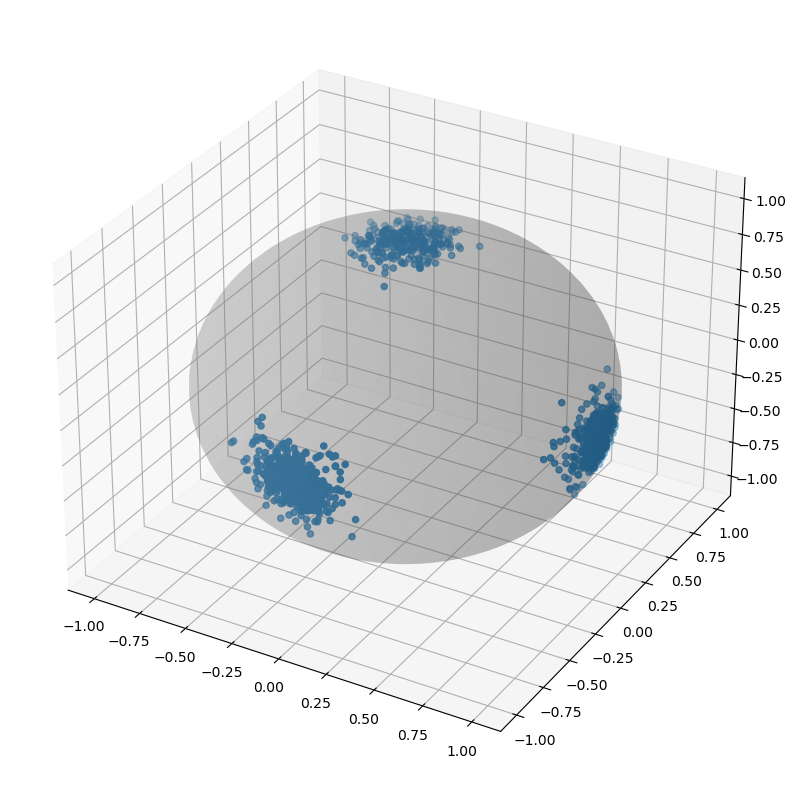

In [64]:
def visualize_forward_diffusion_vMF(t):
    batch_size = 1024
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection="3d")
    t_batch = torch.tensor([t], device='cpu').repeat(batch_size)
    mu = noising_sch(t_batch)
    
    vMF_Mixture_dataloader = torch.utils.data.DataLoader(vMF_Mixture, batch_size=batch_size, shuffle=True)

    vmf_mixture_samples = next(iter(vMF_Mixture_dataloader)) 
    
    dist = BatchedvMF(torch.Tensor(vmf_mixture_samples), mu, device='cpu')
    samples = dist.sample().cpu()

    ax = sphere_plot(ax)
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
    plt.show()
        
visualize_forward_diffusion_vMF(0)


torch.Size([1024, 3])


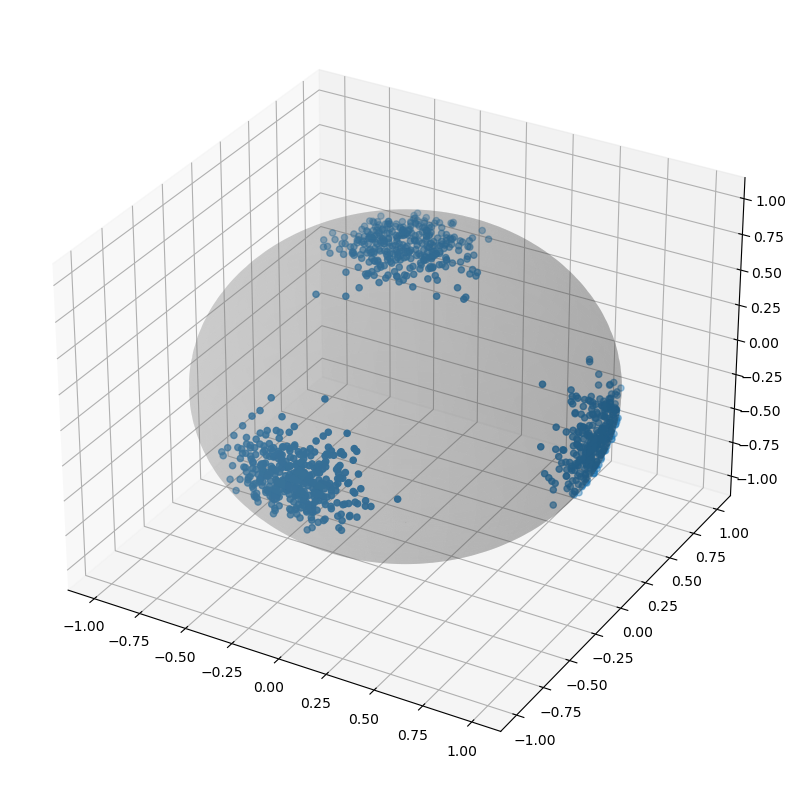

In [65]:
visualize_forward_diffusion_vMF(10)

torch.Size([1024, 3])


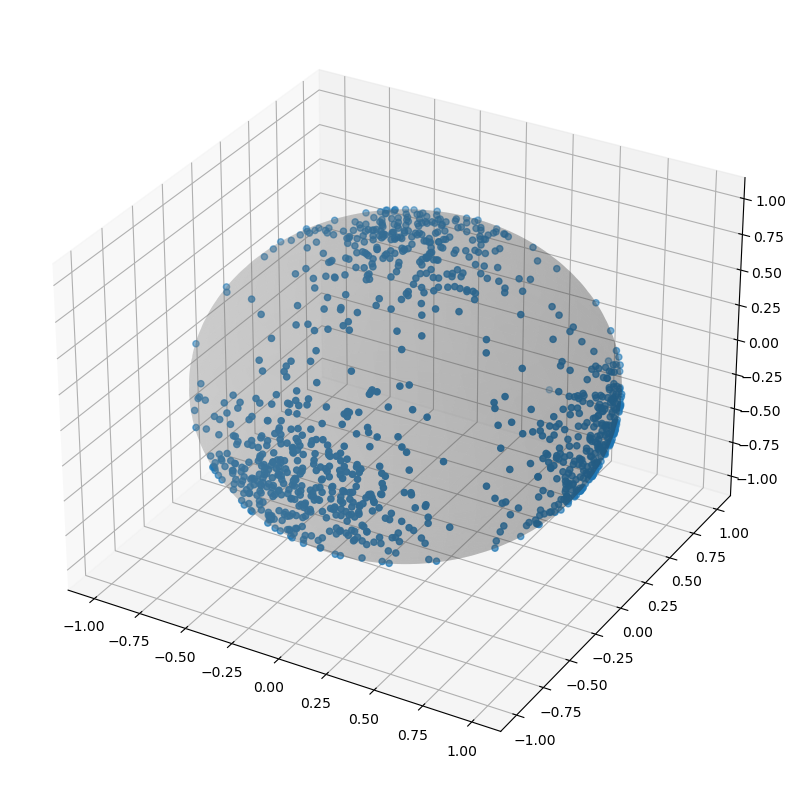

In [66]:
visualize_forward_diffusion_vMF(20)

torch.Size([1024, 3])


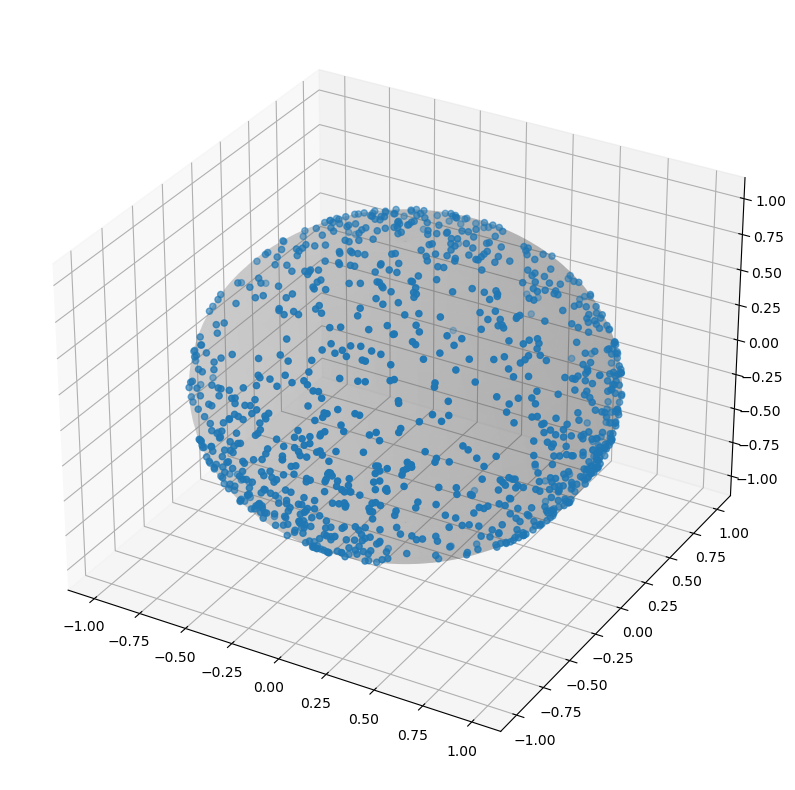

In [71]:
visualize_forward_diffusion_vMF(30)

torch.Size([1024, 3])


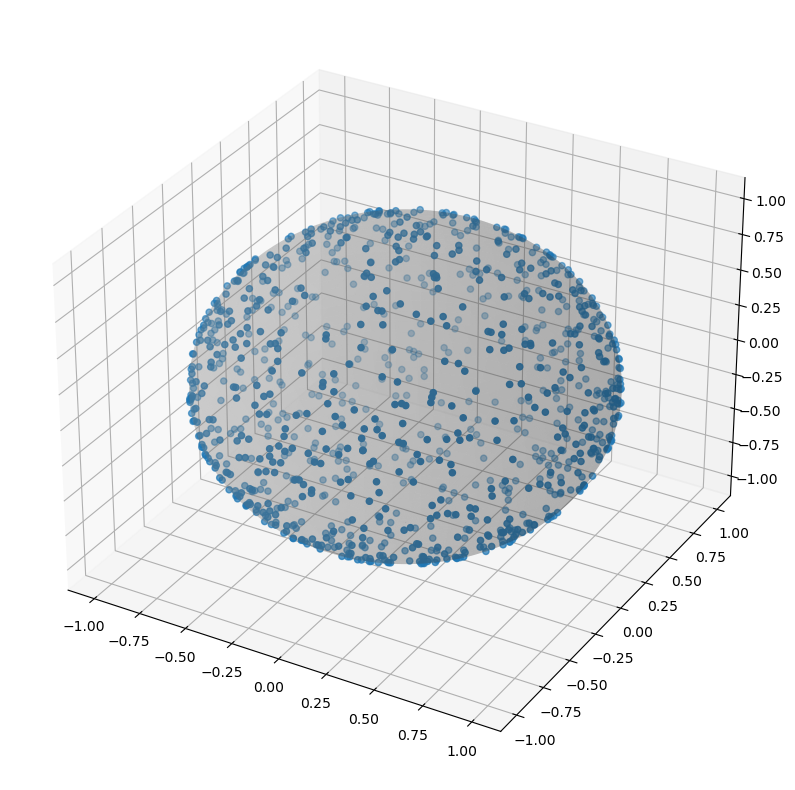

In [69]:
visualize_forward_diffusion_vMF(100)

In [ ]:

import pandas as pd
import geomstats as gs

class SphereDataset(torch.utils.data.Dataset):
    
    def __init__(self, path):
        super().__init__()
        manifold = gs.geometry.hypersphere.Hypersphere(2)
        intrinsic_data = np.genfromtxt(path, delimiter=',', skip_header=True)[1:]
        self.data_on_sphere = manifold.spherical_to_extrinsic(intrinsic_data)
    
    def __len__(self):
        return self.data_on_sphere.shape[0]
    
    def __getitem__(self, idx):
        return self.data_on_sphere[idx]
    
# batch_size = 1280
dataset = SphereDataset('fire.csv')
    
sphere_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
next(iter(sphere_dataloader));